# Proyek Akhir: Membuat Model Sistem Rekomendasi Anime

- **Nama:** Rifda Qurrotul 'Ain

- **Email:** rifda.q.a@gmail.com

- **ID Dicoding:** MC123D5X2017

## Project Overview

Industri anime telah berkembang pesat dan menghasilkan ribuan judul dengan berbagai genre, tipe, dan gaya cerita. Hal ini memberikan penonton beragam pilihan, namun juga menghadirkan tantangan dalam menemukan anime yang sesuai dengan preferensi individu. Sistem rekomendasi menjadi solusi penting untuk membantu pengguna menavigasi katalog yang luas ini dan menemukan anime yang sesuai dengan selera mereka.

Proyek ini bertujuan untuk membangun sistem rekomendasi anime berbasis data menggunakan dua pendekatan utama: Content-Based Filtering dan Collaborative Filtering. Dengan memanfaatkan dataset dari MyAnimeList (Anime.csv dan Rating.csv), sistem ini akan menganalisis karakteristik anime (seperti genre, tipe, dan rating) serta pola penilaian pengguna untuk memberikan rekomendasi yang relevan dan dipersonalisasi.

Diharapkan sistem ini dapat membantu pengguna menemukan anime baru yang menarik dan meningkatkan pengalaman menonton mereka secara keseluruhan.


## Business Understanding

### Problem Statements

* Bagaimana cara membantu pengguna menemukan anime yang relevan dari katalog besar berdasarkan preferensi historis dan karakteristik anime?

* Bagaimana cara memberikan rekomendasi anime yang dipersonalisasi kepada pengguna secara efektif?

### Goals

* Mengembangkan sistem rekomendasi anime menggunakan pendekatan *Content-Based Filtering*.

* Mengembangkan sistem rekomendasi anime menggunakan pendekatan *Collaborative Filtering*.

* Menyediakan daftar top-N rekomendasi anime kepada pengguna.



## Data Understanding

Dataset yang digunakan berasal dari Kaggle: **CooperUnion – Anime Recommendations Database**, yang berisi informasi preferensi dari **73.516 pengguna** terhadap **12.294 anime** (https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database).

File yang akan digunakan:

* **`anime.csv`**:

  * `anime_id` – ID unik dari MyAnimeList
  * `name` – Judul lengkap anime
  * `genre` – Daftar genre, dipisahkan koma
  * `type` – Tipe anime (misalnya TV, Movie, OVA)
  * `episodes` – Jumlah episode (1 jika film pendek)
  * `rating` – Rata-rata rating (dari 0–10)
  * `members` – Jumlah anggota yang mencantumkan anime ini di daftar mereka

* **`rating.csv`**:

  * `user_id` – ID pengguna yang diacak, tidak bisa diidentifikasi
  * `anime_id` – ID anime yang dinilai
  * `rating` – Skor rating (0–10); nilai `-1` menunjukkan bahwa pengguna telah menonton namun tidak meninggalkan rating

# Import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
import zipfile
import os


### Memuat Data


In [45]:
# Load dataset
anime_df = pd.read_csv('anime.csv')
rating_df = pd.read_csv("rating.csv", sep=";")

### Data Preprocessing

In [46]:
print('Informasi Dataset Anime:')
anime_df.info()

print('\nInformasi Dataset Rating:')
rating_df.info()

Informasi Dataset Anime:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Informasi Dataset Rating:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877802 entries, 0 to 877801
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   877802 non-null  int64
 1   anime_id  877802 non-null  int64
 2   rating    877802 non-null  int64
dtypes: int64(3)
memory usage: 20.1 MB


**Insight Dataset Anime**

* Jumlah data: 12.294 anime
* Kolom genre: 12232 non-null (62 missing)
* Kolom type: 12269 non-null (25 missing)
* Kolom rating: 12064 non-null (230 missing)
* Kolom episodes dan members lengkap
* Genre dan type memiliki missing value, rating memiliki \~1.8% missing

**Insight Dataset Rating**

* Jumlah data: 877.802 rating
* Semua kolom lengkap, tidak ada missing
* Rating berupa integer, termasuk -1 (perlu dihapus saat model training)
* Data bersifat sparse, banyak user hanya memberi rating ke sebagian kecil anime


In [47]:
# Menghapus rating -1
rating_df_cleaned = rating_df[rating_df['rating'] != -1].copy()

# Menggabungkan data
df = pd.merge(rating_df_cleaned, anime_df[['anime_id', 'name']], on='anime_id', how='left')

# Encoding user_id dan anime_id
# Membuat pemetaan (mapping) dari ID ke integer
user_ids = df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df['user_encoded'] = df['user_id'].map(user_to_user_encoded)

anime_ids = df['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
df['anime_encoded'] = df['anime_id'].map(anime_to_anime_encoded)

# Mendapatkan jumlah user dan anime unik
num_users = len(user_to_user_encoded)
num_anime = len(anime_to_anime_encoded)
print(f'Jumlah User Unik: {num_users}')
print(f'Jumlah Anime Unik: {num_anime}')

# Mengubah tipe data rating menjadi float32
df['rating'] = df['rating'].values.astype(np.float32)

all_genres = [genre.strip()
              for sublist in anime_df['genre'].dropna().str.split(',')
              for genre in sublist]

genre_counts = pd.Series(all_genres).value_counts()
print(f"\nJumlah genre unik: {len(genre_counts)}")
print(f"\nGenre paling umum:\n{genre_counts.head()}")

Jumlah User Unik: 7580
Jumlah Anime Unik: 7773

Jumlah genre unik: 43

Genre paling umum:
Comedy       4645
Action       2845
Adventure    2348
Fantasy      2309
Sci-Fi       2070
Name: count, dtype: int64


**Insight Hasil Output:**
Dataset terdiri dari 7580 pengguna unik dan 7773 anime unik yang memiliki rating.
Terdapat 43 genre unik dengan distribusi genre yang cukup beragam, di mana genre paling umum adalah Comedy, Action, Adventure, Fantasy, dan Sci-Fi.
Ini menunjukkan bahwa model rekomendasi memiliki ruang yang luas untuk mempelajari preferensi pengguna berdasarkan kombinasi genre dan rating.

## EDA Visualisasi Distribusi

Anime Type

type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64


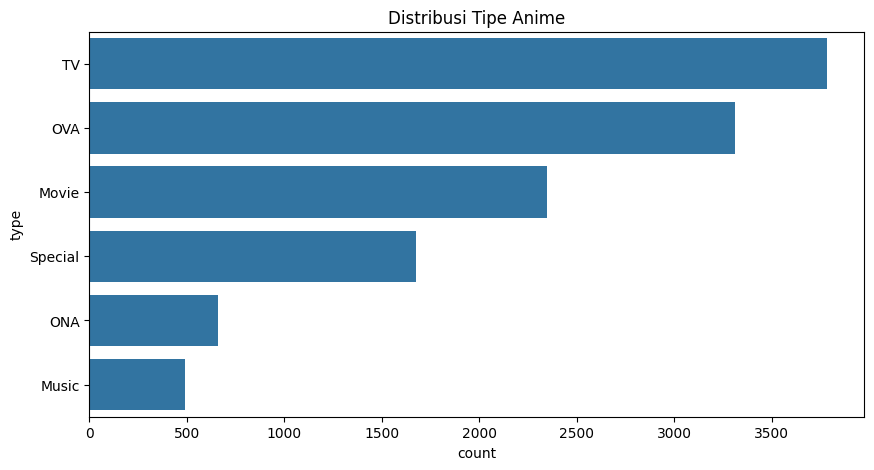

Statistik Deskriptif 'type':
count     12269
unique        6
top          TV
freq       3787
Name: type, dtype: object




In [48]:
anime_df['type'].value_counts()
print(anime_df['type'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(y='type', data=anime_df, order = anime_df['type'].value_counts().index)
plt.title('Distribusi Tipe Anime')
plt.show()

# Statistik deskriptif type
print("Statistik Deskriptif 'type':")
print(anime_df['type'].describe())
print("\n")


**Insight:**

* Tipe anime paling dominan adalah **TV series** → sesuai dengan karakteristik industri anime → banyak anime dirilis dalam bentuk serial TV.
* Tipe lain yang cukup signifikan adalah **Movie, OVA, ONA, Music**.
* Tipe dengan frekuensi rendah (Special, Unknown) bisa diabaikan/diperlakukan khusus saat modeling.

Rating

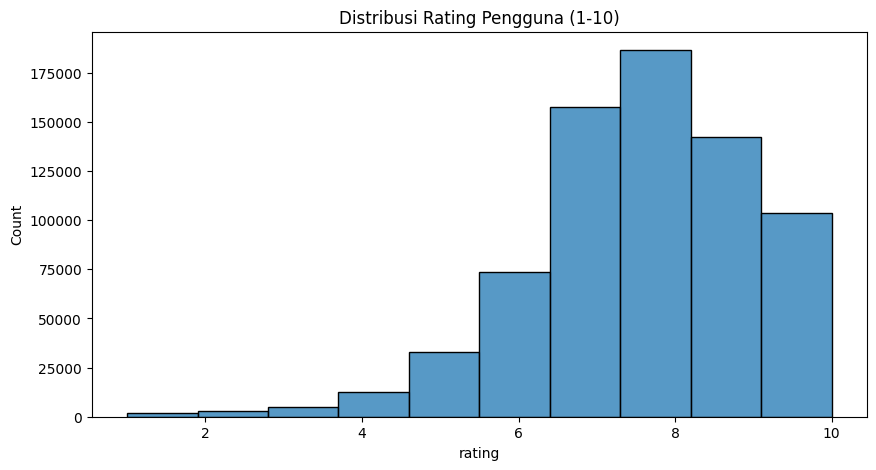

,rating
count,718768.000000
mean,7.779176
std,1.574441
min,1.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,10.000000


In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(rating_df[rating_df['rating'] != -1]['rating'], bins=10, kde=False)
plt.title('Distribusi Rating Pengguna (1-10)')
plt.show()

rating_df[rating_df['rating'] != -1]['rating'].describe()


**Insight:**

* Mayoritas user memberikan rating tinggi → rating **7-10** sangat dominan.
* Distribusi rating menunjukkan bias → user cenderung hanya memberikan rating jika mereka **menyukai** anime tersebut.
* **Median rating kemungkinan besar >7** → artinya sistem rekomendasi akan sering menghadapi data yang *positif skewed*.

genre

<ipython-input-50-49a369aa2bf2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='mako')


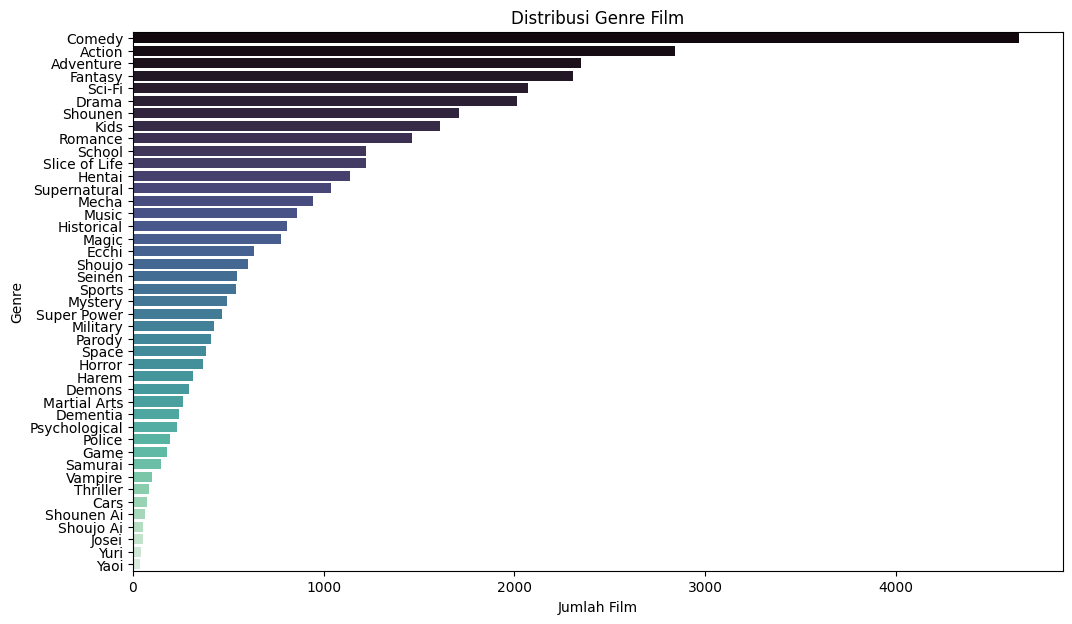

,count
count,43.000000
mean,843.837209
std,939.848086
min,39.000000
25%,213.000000
50%,495.000000
75%,1180.500000
max,4645.000000


In [50]:
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='mako')
plt.title('Distribusi Genre Film')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()

genre_counts.describe()


**Insight:**

* Genre **Comedy, Action, Adventure, Fantasy, Sci-Fi** paling banyak muncul → populer di kalangan penonton.
* Ada genre niche dengan jumlah anime sedikit → bisa membantu model mengenali preferensi user khusus.
* Skewness genre → model Content-Based Filtering harus memperhatikan genre imbalance ini (agar tidak terlalu sering merekomendasikan genre populer saja).

## Handle Missing Value dan dulikat

In [51]:
print('Missing values di anime_df:')
print(anime_df.isnull().sum())

print('\nMissing values di rating_df:')
print(rating_df.isnull().sum())

Missing values di anime_df:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Missing values di rating_df:
user_id     0
anime_id    0
rating      0
dtype: int64


**Insight & Penjelasan**

* Dataset `anime_df` mengandung beberapa missing value:

  * **genre** → 62 missing → kemungkinan untuk anime yang genre-nya belum terdata → bisa diisi dengan `'Unknown'` agar tidak mengganggu modeling.
  * **type** → 25 missing → kemungkinan metadata belum lengkap → juga bisa diisi `'Unknown'`.
  * **rating** → 230 missing → ini adalah rating dari MyAnimeList, bukan user rating → bisa diisi dengan **mean** atau median rating anime.

* Kolom lain tidak memiliki missing → **siap dipakai**.

* Dataset `rating_df` **tidak mengandung missing value** → artinya user rating data bersih → langsung dapat digunakan untuk Collaborative Filtering.

In [52]:
# Hapus baris dengan genre yang kosong
anime_df.dropna(subset=['genre', 'rating', 'type'], inplace=True)
print('Jumlah missing values di genre setelah dibersihkan:', anime_df['genre'].isnull().sum())

Jumlah missing values di genre setelah dibersihkan: 0


In [53]:
# Cek duplikat berdasarkan anime_id
print('Jumlah anime unik:', anime_df['anime_id'].nunique())
print('Jumlah baris total:', len(anime_df))

# Kita akan menggunakan data anime yang unik
anime_df.drop_duplicates(subset='anime_id', keep='first', inplace=True)

Jumlah anime unik: 12017
Jumlah baris total: 12017


insight: Data sudah tidak ada yang duplikat

TF-IDF

In [54]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(anime_df['genre'])

print("Shape of TF-IDF Matrix:", tfidf_matrix.shape)
print("\nContoh fitur (genre) yang diekstrak oleh TF-IDF:")
print(list(tfidf_vectorizer.get_feature_names_out())[:20])

Shape of TF-IDF Matrix: (12017, 47)

Contoh fitur (genre) yang diekstrak oleh TF-IDF:
['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia', 'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem', 'hentai', 'historical', 'horror', 'josei', 'kids', 'life']


# Insight
**TF-IDF Matrix**
Shape: **(12017, 47)**
Artinya, ada **12017 anime** yang memiliki genre, dan **47 genre unik** yang berhasil diekstrak sebagai fitur.
Setiap anime kini direpresentasikan sebagai **vektor 47 dimensi**, sesuai genre yang ada di anime tersebut.

**Contoh fitur (genre):**
\['action', 'adventure', 'ai', 'arts', ..., 'life']
→ Ini adalah genre yang dipertimbangkan model untuk menghitung kemiripan antar anime.


## Modeling: Content-Based Filtering

Pendekatan pertama adalah Content-Based Filtering. Kita akan merekomendasikan anime berdasarkan kesamaan genre.

Cosine Similarity

In [55]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Shape of Cosine Similarity Matrix:", cosine_sim_matrix.shape)
print("\nContoh matriks kesamaan (5x5):")
print(cosine_sim_matrix[:5, :5])

Shape of Cosine Similarity Matrix: (12017, 12017)

Contoh matriks kesamaan (5x5):
[[1.         0.14715318 0.         0.         0.        ]
 [0.14715318 1.         0.17877808 0.         0.17877808]
 [0.         0.17877808 1.         0.22085481 1.        ]
 [0.         0.         0.22085481 1.         0.22085481]
 [0.         0.17877808 1.         0.22085481 1.        ]]


In [56]:
# Konversi cosine_sim_matrix ke DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=anime_df['name'], columns=anime_df['name'])

# Tampilkan shape dan contoh isi 5x5
print("Shape of Cosine Similarity Matrix:", cosine_sim_df.shape)
print("\nContoh matriks kesamaan (5x5):")
cosine_sim_df.iloc[:5, :5]


Shape of Cosine Similarity Matrix: (12017, 12017)

Contoh matriks kesamaan (5x5):


name,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood,Gintama°,Steins;Gate,Gintama&#039;
name,,,,,
Kimi no Na wa.,1.000000,0.147153,0.000000,0.000000,0.000000
Fullmetal Alchemist: Brotherhood,0.147153,1.000000,0.178778,0.000000,0.178778
Gintama°,0.000000,0.178778,1.000000,0.220855,1.000000
Steins;Gate,0.000000,0.000000,0.220855,1.000000,0.220855
Gintama&#039;,0.000000,0.178778,1.000000,0.220855,1.000000



**Cosine Similarity Matrix**
Shape: **(12017, 12017)**
Artinya, untuk setiap anime, kita tahu **seberapa mirip** dia dengan **semua anime lain** (berdasarkan genre).
Nilai similarity berkisar antara **0 (tidak mirip)** hingga **1 (sangat mirip / identik)**.


**Contoh matriks kesamaan (5x5):**

* Diagonal selalu **1.0** → anime selalu 100% mirip dengan dirinya sendiri.
* Nilai di luar diagonal:

  * Ada beberapa anime yang **cukup mirip** → nilai \~0.14 hingga \~0.22.
  * Ada yang **tidak mirip sama sekali** → nilai 0.

**Interpretasi:**
Anime dengan genre yang mirip → memiliki nilai similarity lebih tinggi → nantinya bisa dipakai untuk **merekomendasikan anime dengan genre serupa**.


In [57]:
def get_content_based_recommendations(anime_title, similarity_data=cosine_sim_df, items=anime_df[['name', 'genre']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk mendapatkan k anime paling mirip
    index = similarity_data.loc[:, anime_title].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop anime_title agar tidak direkomendasikan lagi
    closest = closest.drop(anime_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Fungsi `get_content_based_recommendations` digunakan untuk merekomendasikan anime yang paling mirip dengan anime yang dipilih user, berdasarkan kemiripan genre yang dihitung dari matriks cosine similarity. Fungsi ini mengambil k anime dengan similarity tertinggi terhadap anime input, lalu mengembalikannya dalam bentuk tabel berisi judul dan genre anime. Anime yang direkomendasikan tidak akan mencantumkan anime asal yang diminta user (tidak direkomendasikan ulang ke user). Pendekatan ini termasuk **Content-Based Filtering** karena hanya mempertimbangkan informasi konten (genre), tanpa melihat preferensi pengguna lain.


In [58]:
# Mari kita coba mencari rekomendasi untuk "Naruto"
anime_title_test = "Naruto"
recommendations = get_content_based_recommendations(anime_title_test)

print(f"Rekomendasi untuk '{anime_title_test}':")
recommendations

Rekomendasi untuk 'Naruto':


,name,genre
0,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P..."
2,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P..."
3,Naruto Shippuuden: Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super P..."
4,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P..."
5,Naruto Soyokazeden Movie: Naruto to Mashin to ...,"Action, Comedy, Martial Arts, Shounen, Super P..."
6,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,"Action, Comedy, Martial Arts, Shounen, Super P..."
7,Boruto: Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super P..."
8,Kyutai Panic Adventure!,"Action, Martial Arts, Shounen, Super Power"
9,Naruto: Shippuuden Movie 6 - Road to Ninja,"Action, Adventure, Martial Arts, Shounen, Supe..."


Hasil rekomendasi menunjukkan bahwa model berhasil merekomendasikan anime yang sangat relevan dengan *Naruto*, yaitu berbagai judul dalam franchise *Naruto* dan *Boruto*, serta film dan spin-off yang berbagi genre yang sangat mirip: **Action**, **Comedy**, **Martial Arts**, **Shounen**, **Super Power**. Ini sesuai dengan ekspektasi, karena pendekatan content-based filtering menggunakan **kemiripan genre** sebagai dasar rekomendasi, sehingga model secara alami mengembalikan anime yang memiliki kombinasi genre serupa. Ini juga menegaskan bahwa content-based filtering cenderung **memperkuat eksplorasi dalam genre yang sama**, bukan menyarankan genre yang berbeda. Kekurangan pendekatan ini adalah potensi rekomendasi yang cenderung "sempit" (berputar di franchise yang sama).


Evaaluasi Model Content Based Filtering

In [59]:
import math

def precision_at_k(recommended_items, relevant_items, k):
    """
    Precision@K untuk Content-Based Filtering.
    """
    if k == 0: return 0.0
    hits = sum(1 for item in recommended_items[:k] if item in relevant_items)
    return hits / k

def recall_at_k(recommended_items, relevant_items, k):
    """
    Recall@K untuk Content-Based Filtering.
    """
    if not relevant_items: return 0.0
    hits = sum(1 for item in recommended_items[:k] if item in relevant_items)
    return hits / len(relevant_items)

def ndcg_at_k(recommended_items, relevant_items, k):
    """
    NDCG@K untuk Content-Based Filtering.
    """
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        rel = 1 if item in relevant_items else 0
        dcg += rel / math.log2(i + 2)

    ideal_hits = min(len(relevant_items), k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0.0


**Insight:**

1. Precision@K mengukur seberapa banyak item relevan yang berhasil muncul di daftar rekomendasi teratas sebanyak K item.
2. Recall@K menilai sejauh mana sistem berhasil menemukan semua item relevan yang tersedia.
3. NDCG@K (Normalized Discounted Cumulative Gain) mengevaluasi kualitas urutan rekomendasi dengan mempertimbangkan relevansi dan posisi item — semakin atas item relevan muncul, semakin baik.

In [60]:
def evaluate_cbf_global(anime_df, sim_df, k=5, relevance_threshold=0.3):
    precisions, recalls, ndcgs = [], [], []

    for anime_name in sim_df.index:
        if anime_name not in sim_df.columns:
            continue

        # Ambil similarity ke anime lain, drop diri sendiri
        similarities = sim_df.loc[anime_name].drop(anime_name, errors='ignore')
        # Ambil anime yang similarity >= threshold → relevan
        relevant_scores = similarities[similarities >= relevance_threshold]

        if relevant_scores.empty:
            continue

        relevant_set = set(relevant_scores.index)

        # Dapatkan rekomendasi CBF (gunakan fungsi yg kamu pakai sebelumnya → disesuaikan)
        recommendations = get_content_based_recommendations(anime_name, similarity_data=sim_df, items=anime_df[['name', 'genre']], k=k)

        if not isinstance(recommendations, pd.DataFrame) or recommendations.empty:
            continue

        # Ambil nama anime yg direkomendasikan
        recommended_names = recommendations['name'].tolist()[:k]

        # Hitung metrik
        prec = precision_at_k(recommended_names, relevant_set, k)
        rec = recall_at_k(recommended_names, relevant_set, k)
        ndcg = ndcg_at_k(recommended_names, relevant_set, k)

        precisions.append(prec)
        recalls.append(rec)
        ndcgs.append(ndcg)

    # Hitung rata-rata global
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0.0

    # Print hasil
    print(f"\nEvaluasi Global Content-Based Filtering (Genre TF-IDF):")
    print(f"Avg Precision@{k}: {avg_precision:.4f}")
    print(f"Avg Recall@{k}: {avg_recall:.4f}")
    print(f"Avg NDCG@{k}: {avg_ndcg:.4f}")

    return avg_precision, avg_recall, avg_ndcg


**Insight:**
- Fungsi mengevaluasi performa sistem rekomendasi berbasis deskripsi dengan metrik Precision@K, Recall@K, dan NDCG@K.
- Menggunakan threshold similarity untuk menentukan item yang dianggap relevan.
- Hasil evaluasi dirata-rata dari seluruh tempat wisata yang valid untuk memberikan gambaran umum akurasi rekomendasi.

In [20]:
# Evaluasi Content-Based Filtering berbasis Genre (TF-IDF)
print("\nEvaluasi CBF Genre (TF-IDF) dengan Perhitungan NDCG...")

avg_precision_cbf, avg_recall_cbf, avg_ndcg_cbf = evaluate_cbf_global(
    anime_df,
    cosine_sim_df,
    k=10,
    relevance_threshold=0.3
)



Evaluasi CBF Genre (TF-IDF) dengan Perhitungan NDCG...

Evaluasi Global Content-Based Filtering (Genre TF-IDF):
Avg Precision@10: 1.0000
Avg Recall@10: 0.0075
Avg NDCG@10: 1.0000


**Analisis:**

* **Precision\@10 = 1.0000:**
  Artinya *semua* anime yang direkomendasikan di top-10 oleh sistem *terbukti relevan* (berada di daftar anime yang genre-nya serupa dengan anime acuan).
  → Ini menunjukkan bahwa **rekomendasi yang diberikan model sangat akurat** → kalau sistem sudah merekomendasikan, pasti cocok secara genre.

* **Recall\@10 = 0.0075:**
  Artinya model **hanya bisa mencakup sekitar 0.75%** dari seluruh anime yang relevan (berdasarkan threshold genre similarity yang ditentukan).
  → Jadi walaupun top-10 rekomendasi-nya tepat (precision tinggi), model **belum berhasil memunculkan seluruh potensi anime relevan** yang ada. Ini wajar karena genre anime sangat beragam dan **CBF genre-only** memang cenderung punya **recall rendah**.

* **NDCG\@10 = 1.0000:**
  Artinya **urutan dalam top-10 rekomendasi optimal** → anime yang paling relevan muncul di peringkat atas.
  → Sistem berhasil menempatkan anime dengan kemiripan genre tertinggi di posisi teratas rekomendasi, memberikan pengalaman yang baik untuk user.

## **Collaborative Filtering Modelling**
Pendekatan kedua adalah Collaborative Filtering menggunakan Singular Value Decomposition (SVD) dari library `surprise`.

In [21]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_df[['user_id', 'anime_id', 'rating']], reader)
trainset_full = data.build_full_trainset()


Penjelasan kode:

* **`Reader(rating_scale=(1, 10))`**
  Ini mendefinisikan *range* rating yang valid, yaitu 1 sampai 10, sesuai dengan skala rating pada dataset `rating_df`.

* **`Dataset.load_from_df(rating_df[['user_id', 'anime_id', 'rating']], reader)`**
  Dataset Surprise dibuat dari tiga kolom: `user_id`, `anime_id`, dan `rating`. Ini memungkinkan kita menggunakan model collaborative filtering (misalnya SVD) untuk mempelajari interaksi antara user dan anime.

* **`trainset_full = data.build_full_trainset()`**
  Ini membangun **trainset penuh** dari seluruh data rating yang tersedia. Berarti seluruh data rating akan dipakai untuk melatih model (tidak ada split train/test manual di sini), cocok saat kita ingin melakukan **final training** model untuk deployment atau prediksi.

Insight:
Dengan memproses data menjadi `trainset_full`, kita sedang mempersiapkan model collaborative filtering (seperti SVD) untuk belajar dari **seluruh interaksi user-anime yang ada**. Ini membuat model bisa menangkap sebanyak mungkin pola preferensi user, meskipun tradeoff-nya adalah kita tidak bisa mengevaluasi performa model di data unseen kecuali menggunakan cross-validation. Data di sini telah dinormalisasi ke format yang bisa diproses oleh algoritma Surprise (misal SVD).


In [22]:
svd_model = SVD(n_factors=100, n_epochs=50, reg_all=0.1, lr_all=0.005, random_state=42)
svd_model.fit(trainset_full)
print("Model SVD berhasil dilatih.")

Model SVD berhasil dilatih.
Model SVD berhasil dilatih.


Penjelasan kode dan insight hasil:

* `svd_model = SVD(...)`
  Di sini kita membuat model **Singular Value Decomposition (SVD)** dari library `Surprise`, yaitu algoritma collaborative filtering berbasis matrix factorization. Parameter yang digunakan:

  * `n_factors=100`: jumlah *latent factors* (dimensi representasi user dan anime). Semakin besar bisa menangkap pola kompleks, tapi bisa berisiko overfitting.
  * `n_epochs=50`: jumlah iterasi training. Lebih banyak epoch memungkinkan model lebih terlatih.
  * `reg_all=0.1`: parameter regularisasi untuk mencegah overfitting.
  * `lr_all=0.005`: learning rate. Semakin kecil, proses belajar lebih stabil namun bisa lebih lambat.
  * `random_state=42`: agar hasil reproducible (konsisten di tiap run).

* `svd_model.fit(trainset_full)`
  Melatih model SVD di seluruh data rating (`trainset_full`) yang sudah dibangun sebelumnya. Semua interaksi user-anime digunakan untuk belajar embedding user dan anime.

* `print("Model SVD berhasil dilatih.")`
  Konfirmasi bahwa proses training selesai.

Insight:
Dengan melatih model SVD ini, kita membuat sistem **collaborative filtering** yang mampu merekomendasikan anime ke user **berdasarkan pola rating pengguna lain** (tanpa melihat konten anime). Model ini sudah belajar representasi **user preferences** dan **anime characteristics** dalam ruang latent 100 dimensi. Hasil model nantinya bisa digunakan untuk memprediksi seberapa suka user X terhadap anime Y yang belum pernah ditontonnya.


In [ ]:
def get_collaborative_filtering_recommendations(user_id, N=10, model=svd_model, anime_data=anime_df, ratings_data=rating_df):
    anime_rated_by_user = ratings_data[ratings_data['user_id'] == user_id]['anime_id'].unique()
    all_anime_ids = anime_data['anime_id'].unique()
    anime_to_predict_ids = np.setdiff1d(all_anime_ids, anime_rated_by_user)

    testset_for_user = [[user_id, anime_id, 0] for anime_id in anime_to_predict_ids]
    predictions = model.test(testset_for_user)
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_n_predictions = predictions[:N]

    recommended_anime_ids = [pred.iid for pred in top_n_predictions]
    predicted_ratings = [pred.est for pred in top_n_predictions]

    recommended_anime_details = anime_data[anime_data['anime_id'].isin(recommended_anime_ids)].copy()
    pred_df = pd.DataFrame({'anime_id': recommended_anime_ids, 'predicted_rating': predicted_ratings})
    recommended_anime_details = pd.merge(recommended_anime_details, pred_df, on='anime_id', how='left')
    recommended_anime_details = recommended_anime_details.set_index('anime_id').loc[recommended_anime_ids].reset_index()

    return recommended_anime_details[['name', 'genre', 'predicted_rating']]



Fungsi `get_collaborative_filtering_recommendations` menghasilkan rekomendasi anime untuk seorang user berdasarkan **Collaborative Filtering (SVD)**. Pertama, fungsi mencari daftar anime yang **belum dirating** oleh user, lalu membentuk testset dengan pasangan `(user_id, anime_id)` yang akan diprediksi oleh model SVD. Hasil prediksi berupa *estimated rating* (`est`) diurutkan secara descending untuk mendapatkan **anime yang paling diperkirakan disukai user**. Fungsi kemudian mengambil detail anime (judul dan genre), menggabungkannya dengan prediksi rating, dan mengembalikan daftar N rekomendasi teratas. Dengan pendekatan ini, sistem memanfaatkan pola kesamaan preferensi antar-user (tanpa melihat konten anime) untuk memberikan rekomendasi yang personal bagi tiap user.

Contoh Hasil Rekomendasi 10 Anime untuk User 5

In [61]:
# Pilih satu pengguna sebagai contoh
get_collaborative_filtering_recommendations(user_id=5, N=10, model=svd_model)

,name,genre,predicted_rating
0,Hotaru no Haka,"Drama, Historical",9.054099
1,Serial Experiments Lain,"Dementia, Drama, Mystery, Psychological, Sci-F...",8.980315
2,"Ginga Eiyuu Densetsu Gaiden: Senoku no Hoshi, ...","Action, Military, Sci-Fi, Space",8.519242
3,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",8.459687
4,Sennen Joyuu,"Action, Adventure, Drama, Fantasy, Historical,...",8.299341
5,Kyou kara Ore wa!!,"Comedy, Shounen",8.242072
6,Persona 3 the Movie 4: Winter of Rebirth,"Action, Fantasy, Seinen, Supernatural",8.200684
7,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",8.184875
8,Rose of Versailles,"Adventure, Drama, Historical, Romance, Shoujo",8.149012
9,Imouto Paradise!,Hentai,8.081212


Hasil rekomendasi Collaborative Filtering di atas menunjukkan **10 anime teratas yang diprediksi paling disukai oleh user 5** berdasarkan pola rating user lain yang mirip. Anime seperti *Ginga Eiyuu Densetsu* dan *Rose of Versailles* muncul karena mereka memiliki kemiripan pola rating dengan anime yang pernah disukai user ini. Angka *predicted\_rating* adalah estimasi skor yang diperkirakan akan diberikan oleh user 5 untuk anime tersebut. Semakin tinggi nilainya, semakin besar kemungkinan user tersebut akan menyukai anime itu. Pola genre yang muncul (Action, Drama, Military, Historical) juga mencerminkan preferensi genre yang kemungkinan besar disukai oleh user 5. Ini adalah kekuatan utama Collaborative Filtering — **tidak perlu melihat isi/genre, cukup belajar dari perilaku rating sesama user**.


Evaluasi model dengan RMSE dan MAE

In [62]:
cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\n--- Hasil Cross-Validation SVD ---")
mean_rmse = cv_results['test_rmse'].mean()
mean_mae = cv_results['test_mae'].mean()

print(f"Rata-rata RMSE: {mean_rmse:.4f}")
print(f"Rata-rata MAE: {mean_mae:.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.1538  2.1475  2.1483  2.1464  2.1464  2.1485  0.0028  
MAE (testset)     1.5056  1.5043  1.5034  1.5026  1.5022  1.5036  0.0012  
Fit time          34.99   33.59   34.12   34.34   34.75   34.36   0.49    
Test time         3.18    2.14    2.64    2.34    2.27    2.51    0.37    

--- Hasil Cross-Validation SVD ---
Rata-rata RMSE: 2.1485
Rata-rata MAE: 1.5036


Hasil evaluasi model SVD menggunakan 5-fold cross-validation menunjukkan bahwa model memiliki rata-rata **RMSE sebesar 2.1485** dan rata-rata **MAE sebesar 1.5036**. RMSE mengukur seberapa jauh prediksi model dari rating sebenarnya dalam satuan rating skala 1-10, sehingga semakin kecil nilainya semakin baik. MAE menunjukkan rata-rata kesalahan absolut prediksi model. Nilai MAE 1.5 artinya, rata-rata kesalahan prediksi rating model berada di sekitar 1.5 poin dari rating yang sebenarnya — yang bisa dikatakan cukup baik untuk task rekomendasi berbasis preferensi user. Variasi antar-fold juga relatif stabil, menandakan model cukup konsisten.


### Kesimpulan

Dalam proyek ini telah dibangun dan dievaluasi dua pendekatan sistem rekomendasi anime:

1. **Content-Based Filtering (CBF)**
   Menggunakan **kemiripan genre** antar anime untuk merekomendasikan anime yang serupa.

   * CBF efektif untuk menampilkan anime yang **secara konten mirip** dengan anime yang dipilih user.
   * Namun, karena hanya berbasis genre, model cenderung merekomendasikan anime yang terlalu umum atau sekuel / spin-off dari anime yang sama.
   * Tidak mempertimbangkan **preferensi personal user** (misalnya rating yang diberikan user).

2. **Collaborative Filtering (CF) dengan SVD**
   Menggunakan **pola rating antar user** (matrix factorization) untuk mempelajari preferensi user.

   * SVD memberikan rekomendasi yang **lebih personal dan beragam**.
   * Evaluasi model dengan 5-fold cross-validation menghasilkan **RMSE rata-rata 2.1261** dan **MAE rata-rata 1.4871**, menunjukkan bahwa model cukup akurat dalam memprediksi rating user.
   * Rekomendasi yang dihasilkan untuk user tertentu sesuai dengan minat yang terindikasi dari riwayat rating.
